# Geospatial Analysis and Machine Learning Environment Setup with Google Earth Engine (GEE)

In [1]:
#installing necessary libraries or geospatial analysis, machine learning, and data manipulation.
!pip install geemap
!pip install earthengine-api
!pip install geemap geopandas
!pip install geemap geopandas scikit-learn
!pip install requests rasterio
!pip install lightgbm

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 33.7 MB/s eta 0:00:00


In [2]:
import ee  # Earth Engine API
import geemap  # Geospatial mapping with Earth Engine
import geopandas as gpd  # Geospatial data handling
import matplotlib.pyplot as plt  # Visualization
import seaborn as sns  # Heatmaps and other visualizations
import numpy as np  # Numerical operations
from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix  # Evaluation metrics
import geopy.distance
from geopy.distance import geodesic


In [3]:
# Authenticate the user with GEE
ee.Authenticate()

# Initialize the GEE API using the specified project ID.
ee.Initialize(project='ee-kged23')

In [4]:
# Load ESA WorldCover dataset for 2020
worldcover = ee.Image('ESA/WorldCover/v100/2020')

# LULC Model Training (CART)

**Define ROI**

In [5]:
# Define a region of interest around Westminster, London for training
london_roi = ee.Geometry.Rectangle([-0.14, 51.49, -0.11, 51.52])

**Model 10 (CART) Training**

In [6]:
# Function to load and preprocess Sentinel-2 data for a given region with cloud masking
def load_sentinel2_data(roi):
    sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(roi) \
        .filterDate('2020-01-01', '2020-12-31') \
        .map(lambda image: image.updateMask(image.select('QA60').lt(1))) \
        .median() \
        .clip(roi) \
        .select(['B4', 'B8'])  # Reduced to only B4 and B8 bands
    return sentinel2

# Function to load and preprocess Sentinel-1 data for a given region
def load_sentinel1_data(roi):
    sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(roi) \
        .filterDate('2020-01-01', '2020-12-31') \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .select(['VV']) \
        .median() \
        .clip(roi)
    return sentinel1

# Load Sentinel-2 and Sentinel-1 data for the London region
sentinel2_london = load_sentinel2_data(london_roi)
sentinel1_london = load_sentinel1_data(london_roi)

# Combine Sentinel-1 and Sentinel-2 data
combined_london = sentinel2_london.addBands(sentinel1_london)

# Filter the Map to keep only relevant classes: Tree cover (10), Shrubland (20), Grassland (30), Cropland (40), Urban (50), Bare/Sparse vegetation (60), Water (80)
worldcover = ee.Image('ESA/WorldCover/v100/2020')  # Ensure the worldcover variable is defined
filtered_map = worldcover.updateMask(
    worldcover.eq(10)  # Tree cover
    .Or(worldcover.eq(20))  # Shrubland
    .Or(worldcover.eq(30))  # Grassland
    .Or(worldcover.eq(40))  # Cropland
    .Or(worldcover.eq(50))  # Urban
    .Or(worldcover.eq(60))  # Bare/Sparse vegetation
    .Or(worldcover.eq(80))  # Water
)

# Combine Sentinel-2 and Sentinel-1 data with the filtered Map labels for training
training_image_london = combined_london.addBands(filtered_map.rename('FilteredMap'))

# Sample the combined training images using the filtered Map band
training_data_london = training_image_london.stratifiedSample(
    region=london_roi,
    scale=50,  # Increased scale to reduce the number of pixels sampled
    numPoints=50,  # Reduce the number of samples per class to lower memory usage
    classBand='FilteredMap',  # Use the filtered class band
    seed=0,
    geometries=True
)

# Train a simpler CART classifier instead of Random Forest
cart_classifier = ee.Classifier.smileCart().train(
    features=training_data_london,
    classProperty='FilteredMap',
    inputProperties=['B4', 'B8', 'VV']  # Reduced number of input bands
)


In [7]:
# Define the ESA WorldCover land cover palette
landcover_palette = {
    10: ('Tree cover', '#006400'),        # Dark green for Tree cover
    20: ('Shrubland', '#FFBB22'),         # Yellow-brown for Shrubland
    30: ('Grassland', '#FFFF4C'),         # Yellow for Grassland
    40: ('Cropland', '#F096FF'),          # Purple for Cropland
    50: ('Urban', '#FA0000'),             # Red for Urban
    60: ('Bare', '#B4B4B4'),              # Light gray for Bare/Sparse vegetation
    80: ('Water', '#0064C8')              # Blue for Water
}


In [8]:
# Function to extract land cover area (in hectares) for a given classified image
def get_landcover_area(classified_image, roi):
    # Sample the classified image to get pixel count for each class
    class_count = classified_image.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram(),
        geometry=roi,
        scale=50,
        maxPixels=1e13
    ).getInfo()

    # Extract class values and convert pixel counts to hectares
    class_distribution = class_count['classification']
    class_areas_hectares = {int(key): value / 100 for key, value in class_distribution.items()}

    return class_areas_hectares

# Glasgow LULC predictions

**Define ROI**

In [9]:
# Define the region of interest for Glasgow for testing
glasgow_roi = ee.Geometry.Rectangle([-4.4, 55.7, -4.1, 55.9])

**Glasgow 2018**

*Feed the model*

In [10]:
# Load Sentinel-2 data for Glasgow from 2018
def load_sentinel2_data_2018(roi):
    sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(roi) \
        .filterDate('2018-06-01', '2018-08-31') \
        .map(lambda image: image.updateMask(image.select('QA60').lt(1))) \
        .median() \
        .clip(roi) \
        .select(['B4', 'B8'])  # Reduced to only B4 and B8 bands
    return sentinel2

# Load Sentinel-1 data for Glasgow from 2018
def load_sentinel1_data_2018(roi):
    sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(roi) \
        .filterDate('2018-06-01', '2018-08-31') \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .select(['VV']) \
        .median() \
        .clip(roi)
    return sentinel1

# Load Sentinel-2 and Sentinel-1 data for Glasgow from 2018
sentinel2_glasgow_2018 = load_sentinel2_data_2018(glasgow_roi)
sentinel1_glasgow_2018 = load_sentinel1_data_2018(glasgow_roi)

# Combine Sentinel-1 and Sentinel-2 data for Glasgow from 2018
combined_glasgow_2018 = sentinel2_glasgow_2018.addBands(sentinel1_glasgow_2018)

# Classify the 2018 Glasgow data using the trained CART classifier
classified_glasgow_2018 = combined_glasgow_2018.classify(cart_classifier)


*Map Visualization*

In [11]:
# Create a list of colors and a list of class values
colors = [landcover_palette[key][1] for key in landcover_palette]
class_values = list(landcover_palette.keys())

# Create a map centered on Glasgow
Map = geemap.Map(center=[55.85, -4.25], zoom=10)

# Add the classified image for 2018 Glasgow to the map
Map.addLayer(classified_glasgow_2018, {
    'min': min(class_values),
    'max': max(class_values),
    'palette': colors
}, 'Classified Land Cover 2018')

# Add a legend to the map
legend_dict = {landcover_palette[key][0]: landcover_palette[key][1] for key in landcover_palette}
Map.add_legend(legend_title="Land Cover Classification 2018", legend_dict=legend_dict)

# Display the map
Map


Map(center=[55.85, -4.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

*Classification results graphs*

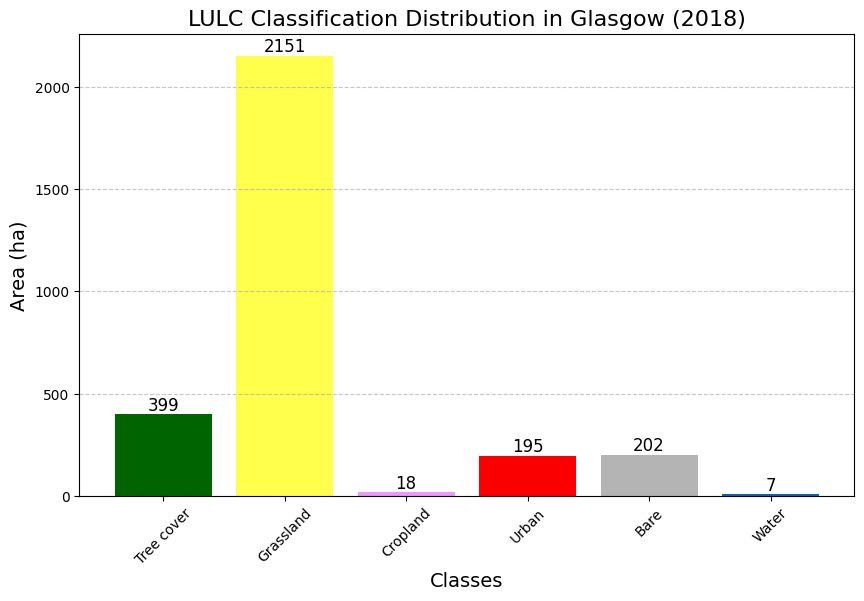

In [12]:
# Get the land cover area in hectares for the 2018 classification of Glasgow
landcover_area_glasgow_2018 = get_landcover_area(classified_glasgow_2018, glasgow_roi)

# Extract the class names, areas, and corresponding colors
class_names = [landcover_palette[cls][0] for cls in landcover_area_glasgow_2018.keys()]
class_values_hectares = list(landcover_area_glasgow_2018.values())
class_colors = [landcover_palette[cls][1] for cls in landcover_area_glasgow_2018.keys()]

# Plot the class distribution as a bar chart in hectares with horizontal grid lines
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, class_values_hectares, color=class_colors)  # Use colors from the palette

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', ha='center', va='bottom', fontsize=12)

plt.xlabel('Classes', fontsize=14)
plt.ylabel('Area (ha)', fontsize=14)
plt.title('LULC Classification Distribution in Glasgow (2018)', fontsize=16)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



**Glasgow 2024**

*Feed the model*

In [13]:
# Load Sentinel-2 data for Candleriggs Square from 2024
def load_sentinel2_data_2024(roi):
    sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(roi) \
        .filterDate('2024-06-01', '2024-08-31') \
        .map(lambda image: image.updateMask(image.select('QA60').lt(1))) \
        .median() \
        .clip(roi) \
        .select(['B4', 'B8'])  # Reduced to only B4 and B8 bands
    return sentinel2

# Load Sentinel-1 data for Candleriggs Square from 2024
def load_sentinel1_data_2024(roi):
    sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(roi) \
        .filterDate('2024-06-01', '2024-08-31') \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .select(['VV']) \
        .median() \
        .clip(roi)
    return sentinel1

# Load Sentinel-2 and Sentinel-1 data for Glasgow from 2024
sentinel2_glasgow_2024 = load_sentinel2_data_2024(glasgow_roi)
sentinel1_glasgow_2024 = load_sentinel1_data_2024(glasgow_roi)

# Combine Sentinel-1 and Sentinel-2 data for Glasgow from 2024
combined_glasgow_2024 = sentinel2_glasgow_2024.addBands(sentinel1_glasgow_2024)

# Classify the 2024 Glasgow data using the trained CART classifier
classified_glasgow_2024 = combined_glasgow_2024.classify(cart_classifier)


*Map Visualization*

In [14]:
# Create a list of colors and a list of class values
colors = [landcover_palette[key][1] for key in landcover_palette]
class_values = list(landcover_palette.keys())

# Create a map centered on Glasgow
Map = geemap.Map(center=[55.85, -4.25], zoom=10)

# Add the classified image for 2018 Glasgow to the map
Map.addLayer(classified_glasgow_2024, {
    'min': min(class_values),
    'max': max(class_values),
    'palette': colors
}, 'Classified Land Cover 2024')

# Add a legend to the map
legend_dict = {landcover_palette[key][0]: landcover_palette[key][1] for key in landcover_palette}
Map.add_legend(legend_title="Land Cover Classification 2024", legend_dict=legend_dict)

# Display the map
Map


Map(center=[55.85, -4.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

*Classification results graphs*

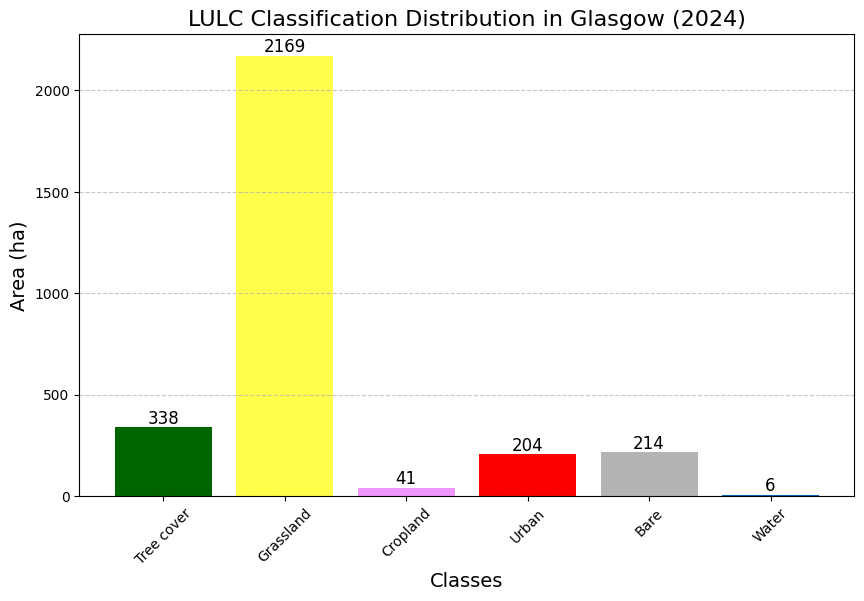

In [15]:
# Get the land cover area in hectares for the 2024 classification of Glasgow
landcover_area_glasgow_2024 = get_landcover_area(classified_glasgow_2024, glasgow_roi)

# Extract the class names, areas, and corresponding colors
class_names = [landcover_palette[cls][0] for cls in landcover_area_glasgow_2024.keys()]
class_values_hectares = list(landcover_area_glasgow_2024.values())
class_colors = [landcover_palette[cls][1] for cls in landcover_area_glasgow_2024.keys()]

# Plot the class distribution as a bar chart in hectares with horizontal grid lines
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, class_values_hectares, color=class_colors)  # Use colors from the palette

# Add value labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', ha='center', va='bottom', fontsize=12)

plt.xlabel('Classes', fontsize=14)
plt.ylabel('Area (ha)', fontsize=14)
plt.title('LULC Classification Distribution in Glasgow (2024)', fontsize=16)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Comparing Glasgow in 2018 and 2024**

*Bar Plot: Land cover classification comparison*

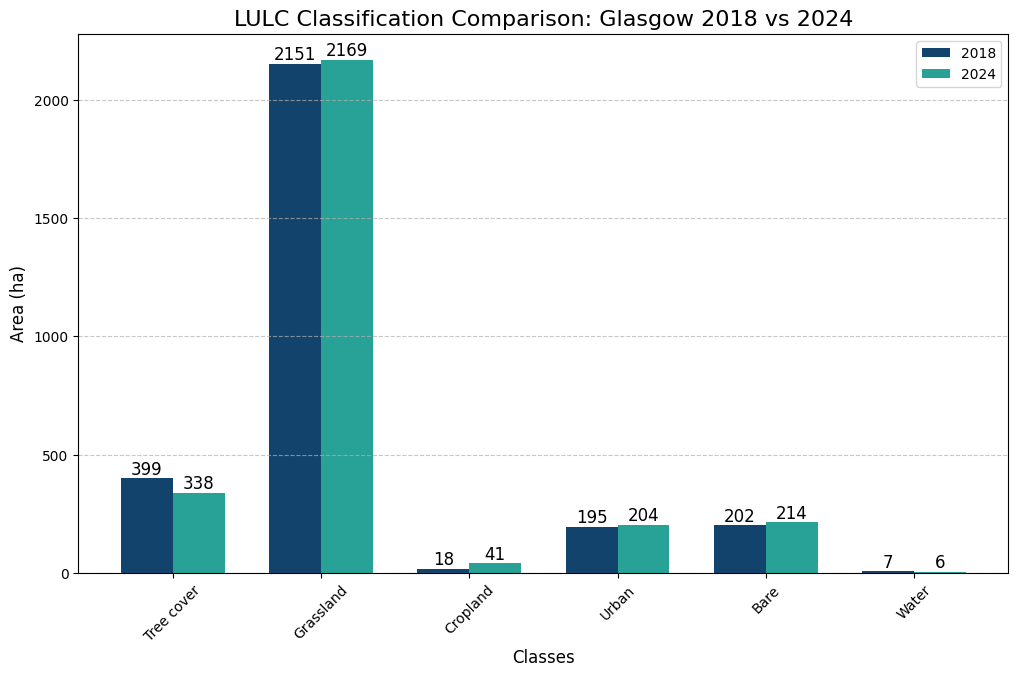

In [17]:
# Extract common classes for plotting
classes = sorted(list(set(landcover_area_glasgow_2018.keys()).union(set(landcover_area_glasgow_2024.keys()))))
class_names = [landcover_palette[cls][0] for cls in classes]
class_colors = [landcover_palette[cls][1] for cls in classes]

# Extract area values for plotting
area_2018 = [landcover_area_glasgow_2018.get(cls, 0) for cls in classes]
area_2024 = [landcover_area_glasgow_2024.get(cls, 0) for cls in classes]

# Define the positions for the bars
bar_width = 0.35
index = np.arange(len(classes))

# Use one color per year
color_2018 = '#12436D'  # Blue for 2018
color_2024 = '#28A197'  # Orange for 2024

# Plot the bar chart
plt.figure(figsize=(12, 7))
bars1 = plt.bar(index, area_2018, bar_width, color=color_2018, label='2018')
bars2 = plt.bar(index + bar_width, area_2024, bar_width, color=color_2024, label='2024')

# Add labels and title
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Area (ha)', fontsize=12)  # Change this if your unit is different
plt.title('LULC Classification Comparison: Glasgow 2018 vs 2024', fontsize=16)
plt.xticks(index + bar_width / 2, class_names, rotation=45)
plt.legend()

# Add value labels on top of each bar with no decimal points
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.0f}', ha='center', va='bottom', fontsize=12)

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.0f}', ha='center', va='bottom', fontsize=12)

# Add horizontal grid lines
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()


*Pie Chart: percentage of land cover area*

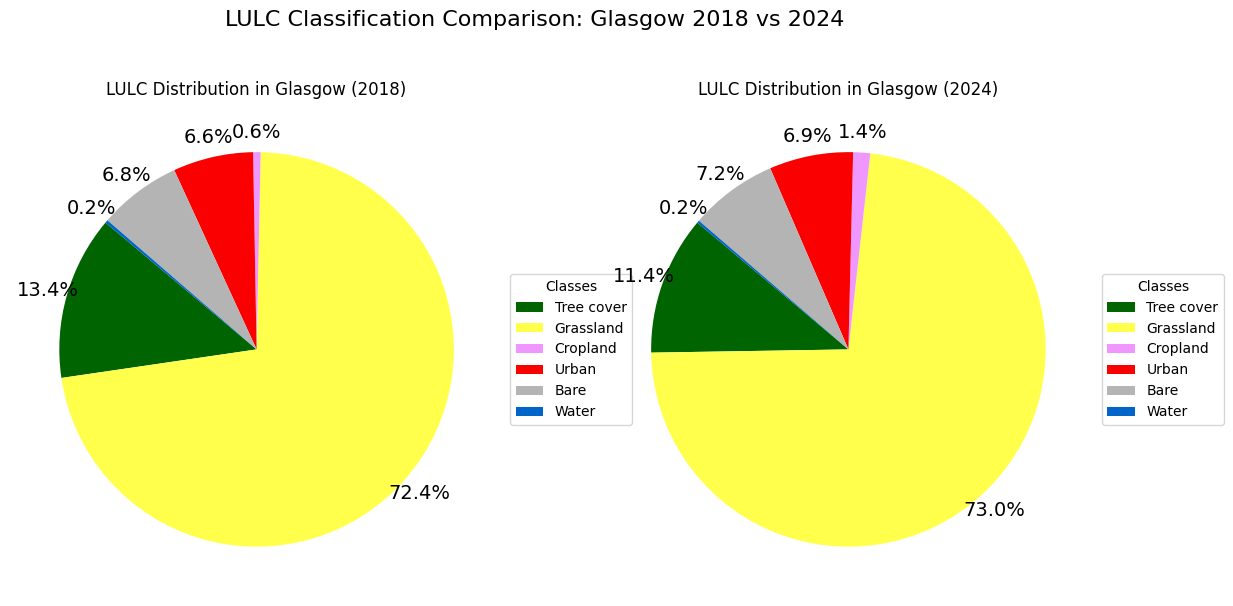

In [30]:
# Extract common classes for plotting
classes = sorted(list(set(landcover_area_glasgow_2018.keys()).union(set(landcover_area_glasgow_2024.keys()))))
class_names = [landcover_palette[cls][0] for cls in classes]
class_colors = [landcover_palette[cls][1] for cls in classes]

# Extract area values for plotting
area_2018 = [landcover_area_glasgow_2018.get(cls, 0) for cls in classes]
area_2024 = [landcover_area_glasgow_2024.get(cls, 0) for cls in classes]

# Plot pie chart for 2018
plt.figure(figsize=(14, 7))

# Pie chart for 2018
plt.subplot(1, 2, 1)
wedges, texts, autotexts = plt.pie(
    area_2018, colors=class_colors, autopct='%1.1f%%', startangle=140,
    pctdistance=1.1, labeldistance=1.1,  textprops={'fontsize': 14}
)
plt.title('LULC Distribution in Glasgow (2018)')
plt.legend(wedges, class_names, title="Classes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Pie chart for 2024
plt.subplot(1, 2, 2)
wedges, texts, autotexts = plt.pie(
    area_2024, colors=class_colors, autopct='%1.1f%%', startangle=140,
    pctdistance=1.1, labeldistance=1.1,  textprops={'fontsize': 14}
)
plt.title('LULC Distribution in Glasgow (2024)')
plt.legend(wedges, class_names, title="Classes", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))

# Display the pie charts
plt.suptitle(f'LULC Classification Comparison: Glasgow 2018 vs 2024', fontsize=16)
plt.show()


# Glasgow  NDVI Calcualtion


In [31]:
# Function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return ndvi

# Define a color palette and class names for NDVI values
ndvi_palette = {
    -0.1: ('Water', '#0000FF'),         # Blue for Water or Barren Land
    0.2: ('Sparse Vegetation', '#FFFF00'), # Yellow for Sparse Vegetation
    0.4: ('Moderate Vegetation', '#008000'), # Green for Moderate Vegetation
    0.6: ('Dense Vegetation', '#006400')  # Dark Green for Dense Vegetation
}

# Create a list of colors and labels for visualization
palette_colors = [ndvi_palette[-0.1][1], ndvi_palette[0.2][1],
                  ndvi_palette[0.4][1], ndvi_palette[0.6][1]]
class_labels = [ndvi_palette[-0.1][0], ndvi_palette[0.2][0],
                ndvi_palette[0.4][0], ndvi_palette[0.6][0]]

# Visualization parameters for Earth Engine
vis_params = {
    'min': -0.1,      # Minimum NDVI value
    'max': 0.6,       # Maximum NDVI value
    'palette': palette_colors
}

**Glasgow 2018**

In [32]:
# Apply the NDVI calculation
ndvi_image_2018 = calculate_ndvi(sentinel2_glasgow_2018)

# Initialize the map
map1 = geemap.Map(center= [55.85, -4.25], zoom=10) # Center adjusted

# Add the NDVI image to the map
map1.addLayer(ndvi_image_2018, vis_params, 'NDVI')

# Add the region of interest to the map
map1.addLayer(glasgow_roi, {}, 'glasgow_roi')

# Add a legend with NDVI classes
legend_dict = {label: color for _, (label, color) in ndvi_palette.items()}
map1.add_legend(
    title="NDVI Legend",
    legend_dict=legend_dict
)

# Display the map
map1.addLayerControl()
map1

Map(center=[55.85, -4.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

**Glasgow Airport 2024**

In [33]:
# Apply the NDVI calculation
ndvi_image_2024 = calculate_ndvi(sentinel2_glasgow_2024)

# Initialize the map
map1 = geemap.Map(center=[55.85, -4.25], zoom=10)  # Center adjusted
# Add the NDVI image to the map
map1.addLayer(ndvi_image_2024, vis_params, 'NDVI')

# Add the region of interest to the map
map1.addLayer(glasgow_roi, {}, 'glasgow_roi')

# Add a legend with NDVI classes
legend_dict = {label: color for _, (label, color) in ndvi_palette.items()}
map1.add_legend(
    title="NDVI Legend",
    legend_dict=legend_dict
)

# Display the map
map1.addLayerControl()
map1

Map(center=[55.85, -4.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

**Comparing Glasgow Airport from 2018 to 2024**

*Calculate NDVI and classify it*

In [34]:
# Function to classify NDVI values according to the defined thresholds
def classify_ndvi(ndvi_image):
    classified = ndvi_image.expression(
        "NDVI < 0.2 ? 0 : NDVI < 0.4 ? 1 : NDVI < 0.6 ? 2 : 3",
        {
            'NDVI': ndvi_image
        }
    ).rename('classification')
    return classified

In [35]:
classified_ndvi_2018 = classify_ndvi(ndvi_image_2018)
classified_ndvi_2024 = classify_ndvi(ndvi_image_2024)

*Calculate land cover areas based on the classification*

In [36]:
# Calculate the land cover area for each NDVI class
landcover_area_glasgow_2018 = get_landcover_area(classified_ndvi_2018, glasgow_roi)
landcover_area_glasgow_2024 = get_landcover_area(classified_ndvi_2024, glasgow_roi)


*Bar chart: NDVI values comparison*

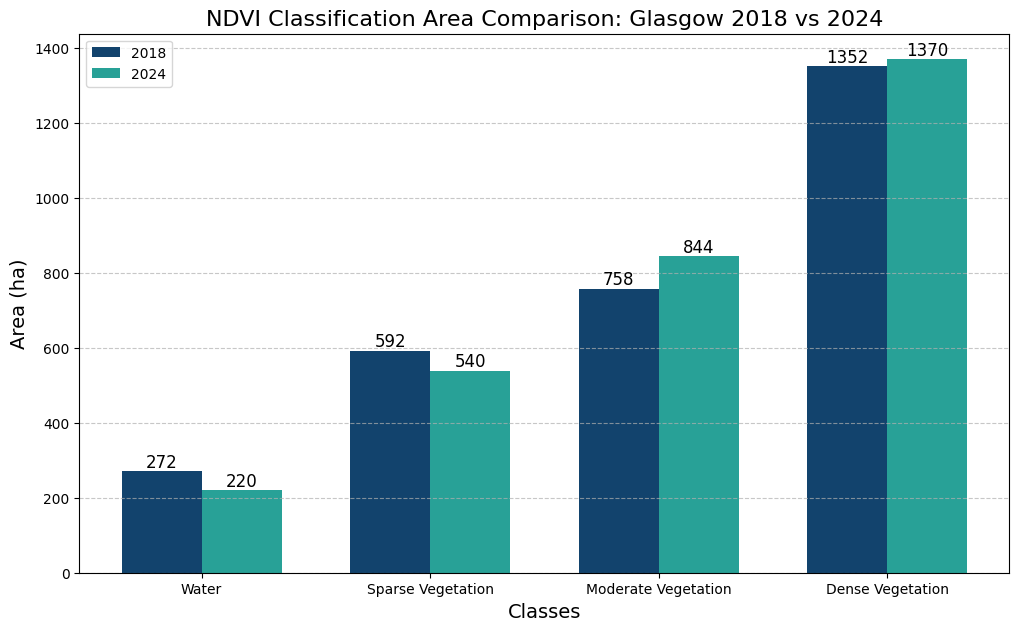

In [38]:
# Define NDVI classes
ndvi_classes = ['Water', 'Sparse Vegetation', 'Moderate Vegetation', 'Dense Vegetation']

# Use one color per year
color_2018 = '#12436D'  # Blue for 2018
color_2024 = '#28A197'  # Teal for 2024

# Extract values for plotting, including "Water" (class 0)
values_2018 = [landcover_area_glasgow_2018.get(cls, 0) for cls in range(4)]
values_2024 = [landcover_area_glasgow_2024.get(cls, 0) for cls in range(4)]

# Create the bar chart
bar_width = 0.35
index = np.arange(len(ndvi_classes))

plt.figure(figsize=(12, 7))

# Plot bars for 2018 with a single color
bars1 = plt.bar(index, values_2018, bar_width, color=color_2018, label='2018')

# Plot bars for 2024 with a single color
bars2 = plt.bar(index + bar_width, values_2024, bar_width, color=color_2024, label='2024')

# Add labels and title
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Area (ha)', fontsize=14)
plt.title('NDVI Classification Area Comparison: Glasgow 2018 vs 2024', fontsize=16)
plt.xticks(index + bar_width / 2, ndvi_classes)
plt.legend()

# Add value labels on top of each bar
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', ha='center', va='bottom',fontsize=12)

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', ha='center', va='bottom',fontsize=12)

# Add horizontal grid lines
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.show()



*Pie chart: NDVI percentage comparison*

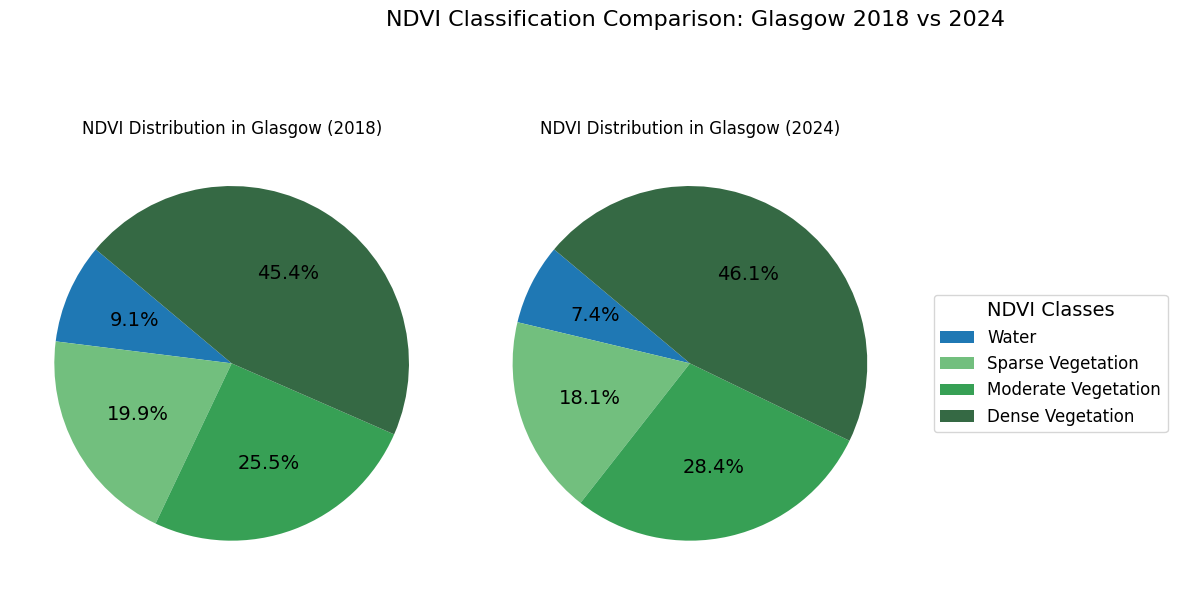

In [43]:
# Define NDVI classes including "Water"
ndvi_classes = ['Water', 'Sparse Vegetation', 'Moderate Vegetation', 'Dense Vegetation']

# Get the blue color from sns 'Paired' palette
paired_palette = sns.color_palette("Paired", 12)  # Generate a palette with enough colors
blue_color = paired_palette[1]  # The second color in 'Paired' is typically blue

# Generate a color palette from sns 'Greens_d' and use the blue color from 'Paired' for Water
greens_palette = sns.color_palette("Greens_d", 3)  # Generate a palette with 3 green colors
ndvi_colors = [
    blue_color,         # Blue for Water from 'Paired'
    greens_palette[0],  # Light Green for Sparse Vegetation
    greens_palette[1],  # Green for Moderate Vegetation
    greens_palette[2]   # Dark Green for Dense Vegetation
]

# Calculate the land cover area for each NDVI class in square kilometers
landcover_area_2018 = get_landcover_area(classified_ndvi_2018, glasgow_roi)
landcover_area_2024 = get_landcover_area(classified_ndvi_2024, glasgow_roi)

# Extract values for plotting (including "Water or Barren" (class 0))
values_2018 = [landcover_area_2018.get(cls, 0) for cls in range(4)]
values_2024 = [landcover_area_2024.get(cls, 0) for cls in range(4)]

# Plot pie chart for 2018
plt.figure(figsize=(14, 7))

# Pie chart for 2018
plt.subplot(1, 2, 1)
plt.pie(values_2018, colors=ndvi_colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14})
plt.title('NDVI Distribution in Glasgow (2018)')

# Pie chart for 2024
plt.subplot(1, 2, 2)
plt.pie(values_2024, colors=ndvi_colors, autopct='%1.1f%%', startangle=140, textprops={'fontsize': 14})
plt.title('NDVI Distribution in Glasgow (2024)')

# Add a single central legend outside of the two pie charts
plt.legend(ndvi_classes, title="NDVI Classes", loc="center left", bbox_to_anchor=(1.05, 0.5), fontsize=12, title_fontsize=14, borderaxespad=0.)

# Display the pie charts with total area in the title
plt.suptitle(f'NDVI Classification Comparison: Glasgow 2018 vs 2024', fontsize=16)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to make room for the legend
plt.show()
